In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# from torch.autograd import Function
# from torchvision import datasets, transforms
# import torch.optim as optim
# import torch.nn as nn
# import torch.nn.functional as F

# import qiskit
# from qiskit import transpile, assemble
# from qiskit.visualization import *

from qiskit import QuantumCircuit, Aer, assemble, execute
from math import pi
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import pandas as pd
import random
import torch
from qiskit.circuit import Parameter
import qiskit.circuit
from copy import deepcopy

In [56]:
from sklearn import preprocessing
devSet = pd.read_csv("./us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)

In [48]:
print(X[0])
print(y[0])

[2.89836403e-01 1.50863757e-01 1.90408762e-02 1.72052079e-01
 1.39492710e-01 1.10632162e-02 8.48417227e-02 9.47754639e-02
 1.16228830e-02 5.28974739e-02 1.50802686e-01 1.49537752e-01
 1.63015617e-01 4.80308698e-04 1.99311121e-02 2.41109533e-01
 9.36315325e-02 1.38082079e-01 1.06262736e-01 1.75745544e-02
 1.12874265e-02 8.53493100e-02 3.47493252e-02 1.00000000e+00
 9.58885902e-02 1.47989902e-01 8.98026736e-02 1.57318322e-01
 1.31442791e-01 9.66065192e-02]
tensor(961.)


In [30]:
class QuantumCircuitProg:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots, num_rotations):
        # --- Circuit definition ---

        self.num_rotations = num_rotations
        self.n_qubits = n_qubits
        # self.weights = weights
        # self.x = x
        self.backend = backend
        self.shots = shots

        alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.params = [qiskit.circuit.Parameter(alphabet[i]) for i in range(num_rotations)]
        
        # Initialize the circuit, add starting Hadamards and num_rotations random gates
        self.qc = QuantumCircuit(self.n_qubits, self.n_qubits)
        self.qc = self.add_hadamards(self.qc, self.n_qubits)
        self.circuit = self.add_random_gates(self.num_rotations)


    def add_hadamards(self, qc, num_qubits):
        for i in range(num_qubits):
            qc.h(i)
        return qc


    def add_random_gates(self, num_gates):

        qc = QuantumCircuit(self.n_qubits, self.n_qubits)
        max_q = self.n_qubits - 1
        rotation_count = 0
        gates_choices = [0, 1, 2, 3]

        while rotation_count < num_gates:
            gate_choice = random.randint(0, 3)
            if gate_choice == 0:
                qubit_choice = random.randint(0, max_q)
                qc.rx(self.params[rotation_count], qubit_choice)
            elif gate_choice == 1:
                qubit_choice = random.randint(0, max_q)
                qc.ry(self.params[rotation_count], qubit_choice)
            elif gate_choice == 2:
                qubit_choice = random.randint(0, max_q)
                qc.rz(self.params[rotation_count], qubit_choice)
            elif gate_choice == 3:
                control_qubit, target_qubit = random.sample(range(0, self.n_qubits), 2)            
                qc.cnot(control_qubit, target_qubit)

            if gate_choice != 3:
                rotation_count += 1

        qc.measure_all()
        # print(qc)
        return qc


    def get_probs(self, counts):
        c = 0
        probs = np.array([0 for i in range(self.n_qubits)])
        for k,v in counts.items():
            bin_string = k.split(' ')[0]
            for i in range(int(v)):
                bin_list = np.array([int(i) for i in bin_string])
                probs += bin_list
            c += 1
        return probs

    
    def initial_rotation_gates(self, X):
        q = 0
        qc = QuantumCircuit(self.n_qubits)
        for i in range(self.n_qubits):
            qc.rz(torch.index_select(X, 0, torch.tensor([i])).item(), q)
            q += 1
        return qc


    def make_copy_circuits(self, x):
        to_ret = []
        
        for dim in x:
            qc_copy, irg_copy, circ_copy = deepcopy(self.qc), deepcopy(self.initial_rotation_gates(torch.tensor(dim))), deepcopy(self.circuit)
            qc_copy = qc_copy + irg_copy + circ_copy
            to_ret.append(qc_copy)
        return to_ret
    
    def run(self, x, thetas):
        out = []

        circs = self.make_copy_circuits(x)
        # print(circs)

        indices = [torch.index_select(thetas, 0, torch.tensor([i])).item() for i in range(self.num_rotations)]
        self.imputed_circuit = self.circuit.assign_parameters(dict(zip(self.params, indices)))

        for dim in x:
            self.qc = self.qc + self.initial_rotation_gates(torch.tensor(dim)) + self.imputed_circuit
            simulator = Aer.get_backend(self.backend)
            result = execute(self.qc, simulator, shots = self.shots).result()
            counts = result.get_counts()
            cs = torch.tensor(self.get_probs(counts), dtype = torch.float32, requires_grad = True)
            out.append(list(self.get_probs(counts)))
        # return self.x.data.copy_(cs.data)#.view(-1, 1)
        # return list(self.get_probs(counts))
        return torch.tensor(out, dtype = torch.float32), circs, self.params



    # def run_premade(self, circ, thetas, x):



In [31]:
###### Define our model
class QuantumCicuitNet(torch.nn.Module):
    def __init__(self, ndim, n_qubits, backend, shots, num_rotations):
        super().__init__()
        # self.thetas = torch.nn.Parameter(torch.tensor(np.random.rand(num_rotations)*.0001, dtype = torch.float32, requires_grad=True))         
        self.QuantumCircuitLayer = QuantumCircuitProg(n_qubits = n_qubits, backend = backend, shots = shots, num_rotations = num_rotations)
        self.relu = torch.nn.ReLU(inplace=True)
        self.linear = torch.nn.Linear(n_qubits * ndim, ndim)  
        
        
    def forward(self, X, thetas):
        out, circuit_copy, params = self.QuantumCircuitLayer.run(X, thetas) # OUT:  torch.Size([100, 1, 10, 10])
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        return out, circuit_copy, params

In [105]:
def get_probs(counts):
    c = 0
    probs = np.array([0 for i in range(5)])
    for k,v in counts.items():
        bin_string = k.split(' ')[0]
        for i in range(int(v)):
            bin_list = np.array([int(i) for i in bin_string])
            probs += bin_list
        c += 1
    return probs

def run(circ):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots = 100).result()
    counts = result.get_counts()
    # cs = torch.tensor(get_probs(counts), dtype = torch.float32, requires_grad = True)
    # out.append(list(self.get_probs(counts)))
    return list(get_probs(counts))


def make_circs(shift_right, shift_left, num_rotations, circuit_copy, params):
    circs = []
    for i in range(len(circuit_copy)):
        for shift in [shift_right, shift_left]:
            cur_indices = [torch.index_select(shift, 0, torch.tensor([i])).item() for i in range(num_rotations)]
            circ_copy = deepcopy(circuit_copy[i])
            circ_copy = circ_copy.assign_parameters(dict(zip(params, cur_indices)))
            circs.append(circ_copy)
    return circs




def calc_gradient(thetas, y_pred, shift_val, num_rotations, circuit_copy, params, grad_output, n_qubits, ndim, x):

    lin = torch.nn.Linear(n_qubits * ndim, ndim)  


    input = thetas
    expectation_z = y_pred
    input_list = input.clone().detach().numpy()

    shift_right = torch.nn.Parameter(torch.tensor(input_list + np.ones(input_list.shape) * shift_val))
    shift_left = torch.nn.Parameter(torch.tensor(input_list - np.ones(input_list.shape) * shift_val))


    grad_circs = make_circs(shift_right, shift_left, num_rotations, circuit_copy, params)

    # print("Expectation right: ", lin(expectation_right))
    # print("Expectation left: ", lin(expectation_left))

    yp_shift_right, cc, p = model(x, shift_right)
    yp_shift_left, cc, p = model(x, shift_left)
    # print("    yp_shift_right: ", yp_shift_right)
    # print("    yp_shift_left: ", yp_shift_left)

    gradient = torch.tensor([yp_shift_right]) - torch.tensor([yp_shift_left]) / 2
    gradients = gradient.T.float()

    print("    Gradients:               ", gradients)

    return torch.mean(gradients)


def mae(real, pred):
    '''
    Calculates MAE of an epoch
    '''
    return torch.abs(real - pred).mean()


In [109]:
num_rotations = 1
n_qubits = 5
ndim = 1

shift_val = pi/2
grad_output = 1e-6


from sklearn import preprocessing
devSet = pd.read_csv("./us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)

x = np.reshape(X[0][0:n_qubits], (ndim, n_qubits))
y = torch.tensor(y.detach().numpy()[0])

print(x)
print(y)

# x = np.reshape(np.random.rand(n_qubits * ndim), (ndim, n_qubits))
# y = torch.tensor([random.randint(0, 400) for i in range(ndim)])
thetas = torch.nn.Parameter(torch.tensor(np.random.rand(num_rotations)*.0001, dtype = torch.float32, requires_grad=True))    

criterion = torch.nn.MSELoss(reduction='sum')
model = QuantumCicuitNet(ndim = ndim, n_qubits = n_qubits, backend = 'qasm_simulator', shots = 100, num_rotations = num_rotations)

print("Starting Theta: ", thetas, "\n") 

for i in range(0, 20):

    print("EPOCH: ", i)

    y_pred, circuit_copy, params = model(x, thetas)
    # print("    YPRED: ", y_pred)

    print("    MAE:                     ", mae(y, y_pred))

    loss = criterion(y_pred, y)
    print("    Loss: ", loss.clone().detach().numpy())
    print("    Current rotation angle:  ", thetas.clone().detach().numpy())
    # print("\n")
    for i in range(0, len(list(y_pred.clone().detach().numpy()))):
        print("    Predicted:               ", list(y_pred.clone().detach().numpy())[i], "    True: ", y.clone().detach().numpy())

    

    grad = calc_gradient(thetas, y_pred, shift_val, num_rotations, circuit_copy, params, grad_output, n_qubits, ndim, x)
    thetas = thetas - grad
    print("    New theta:               ", thetas)
    print("\n")

# print(thetas)
# grad = calc_gradient(thetas, y_pred, shift_val, num_rotations, circuit_copy, params, grad_output)
# new_weights = thetas - grad
# print(new_weights)

# y_pred_new, circuit_copy_new, params_new = model(x, new_weights)


[[0.2898364  0.15086376 0.01904088 0.17205208 0.13949271]]
tensor(961.)
Starting Theta:  Parameter containing:
tensor([9.6089e-05], requires_grad=True) 

EPOCH:  0
    MAE:                      tensor(920.9138, grad_fn=<MeanBackward0>)
    Loss:  848082.25
    Current rotation angle:   [9.608894e-05]
    Predicted:                40.086155     True:  961.0
    Gradients:                tensor([0.7883])
    New theta:                tensor([9.5301e-05], grad_fn=<SubBackward0>)


EPOCH:  1
    MAE:                      tensor(920.4391, grad_fn=<MeanBackward0>)
    Loss:  847208.25
    Current rotation angle:   [9.5300624e-05]
    Predicted:                40.56085     True:  961.0
/Users/heatherbaier/anaconda/envs/qnn/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

In [40]:
print(thetas)
grad = calc_gradient(thetas, y_pred, shift_val, num_rotations, circuit_copy, params, grad_output)
new_weights = thetas - grad
print(new_weights)


y_pred_new, circuit_copy_new, params_new = model(x, new_weights)

print("MAE: ", mae(y, y_pred))


tensor([0.0008], grad_fn=<SubBackward0>)
tensor([0.0026], grad_fn=<SubBackward0>)
MAE:  tensor(142.4740, grad_fn=<MeanBackward0>)


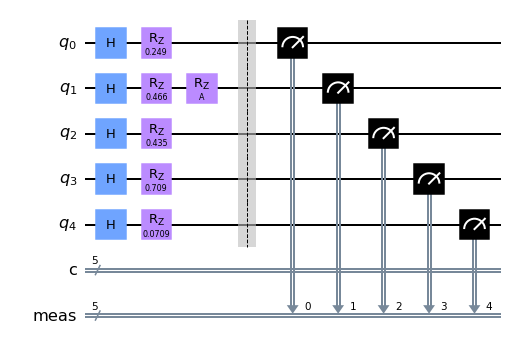

In [8]:
circuit_copy[0].draw('mpl')

In [ ]:
    @staticmethod
    def backward(ctx pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.a, grad_output):
        """ Backwardrray(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

In [295]:
def calc_gradient():

[Parameter(A), Parameter(B)]

In [370]:
def make_circs(shift_right, shift_left, num_rotations, circuit_copy, params):
    circs = []
    for i in range(len(circuit_copy)):
        for shift in [shift_right, shift_left]:
            cur_indices = [torch.index_select(shift, 0, torch.tensor([i])).item() for i in range(num_rotations)]
            circ_copy = deepcopy(circuit_copy[i])
            circ_copy = circ_copy.assign_parameters(dict(zip(params, tmp_indices)))
            circs.append(circ_copy)
    return circs

In [373]:
grad_circs = make_circs(shift_right, shift_left, num_rotations, circuit_copy, params)

In [397]:
shift_val = pi/4
grad_output = .00001


def calc_gradient(thetas, y_pred, shift_val, num_rotations, circuit_copy, params, grad_output):

    input = thetas
    expectation_z = y_pred
    input_list = input.clone().detach().numpy()

    shift_right = torch.nn.Parameter(torch.tensor(input_list + np.ones(input_list.shape) * shift_val))
    shift_left = torch.nn.Parameter(torch.tensor(input_list - np.ones(input_list.shape) * shift_val))


    grad_circs = make_circs(shift_right, shift_left, num_rotations, circuit_copy, params)


    expectation_right = run(grad_circs[0])
    expectation_left  = run(grad_circs[1])

    print("Expectation right: ", expectation_right)
    print("Expectation left: ", expectation_left)


    gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
    gradients = gradient.T.float()

    return torch.mean(gradients * grad_output)

    # print(np.avg())

In [398]:
calc_gradient(thetas, y_pred, shift_val, shift_right, shift_left, num_rotations, circuit_copy, params, grad_output)

Expectation right:  [56, 35, 45, 50, 51]
Expectation left:  [47, 36, 58, 41, 45]


tensor(2.0000e-05)

In [351]:

tmp_indices = [torch.index_select(shift_right, 0, torch.tensor([i])).item() for i in range(num_rotations)]
tmp_indices

copy1 = deepcopy(circuit_copy[0])
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
tmp_params = [qiskit.circuit.Parameter(alphabet[i]) for i in range(2)]


copy1 = copy1.assign_parameters(dict(zip(params, tmp_indices)))

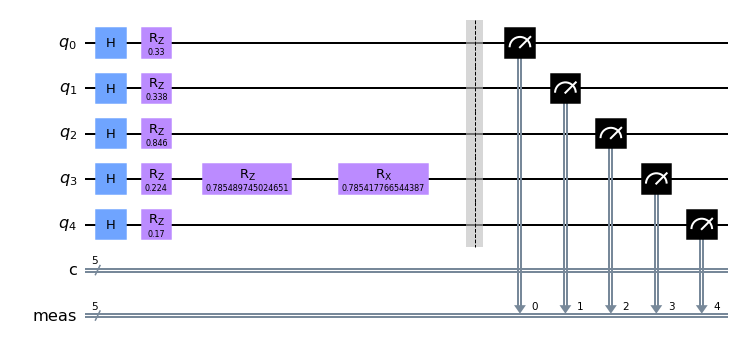

In [352]:
copy1.draw('mpl')

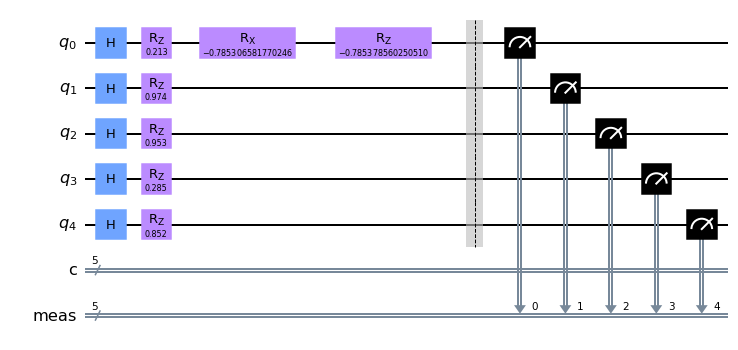

In [322]:
tmp_indices = [torch.index_select(shift_left, 0, torch.tensor([i])).item() for i in range(num_rotations)]
tmp_indices

copy2 = deepcopy(circuit_copy[0])
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
tmp_params = [qiskit.circuit.Parameter(alphabet[i]) for i in range(2)]


copy2 = copy2.assign_parameters(dict(zip(params, tmp_indices)))
copy2.draw('mpl')

In [323]:
def get_probs(counts):
    c = 0
    probs = np.array([0 for i in range(5)])
    for k,v in counts.items():
        bin_string = k.split(' ')[0]
        for i in range(int(v)):
            bin_list = np.array([int(i) for i in bin_string])
            probs += bin_list
        c += 1
    return probs

def run(circ):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots = 100).result()
    counts = result.get_counts()
    # cs = torch.tensor(get_probs(counts), dtype = torch.float32, requires_grad = True)
    # out.append(list(self.get_probs(counts)))
    return list(get_probs(counts))

In [324]:
run(copy1)
run(copy2)

[59, 40, 45, 39, 62]

In [334]:
input = thetas
expectation_z = y_pred
input_list = input.clone().detach().numpy()

shift_right = torch.nn.Parameter(torch.tensor(input_list + np.ones(input_list.shape) * pi/4))
shift_left = torch.nn.Parameter(torch.tensor(input_list - np.ones(input_list.shape) * pi/4))

# copy1 = deepcopy(circuit_copy)

expectation_right = run(copy1)
expectation_left  = run(copy2)

grad_output = .00001

gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
gradients = gradient.T.float()

print(gradients * grad_output)

tensor([[ 5.0000e-05],
        [-1.0000e-05],
        [ 3.0000e-05],
        [-9.0000e-05],
        [-1.5000e-04]])


In [236]:
gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
gradients.append(gradient)
gradients = np.array([gradients]).T
return torch.tensor([gradients]).float() * grad_output.float(), None, None

Parameter containing:
tensor([5.4432e-05, 1.2048e-05], requires_grad=True)

In [235]:
print(shift_right)
print(shift_left)


[0.7854526  0.78541021]
[-0.78534373 -0.78538612]


In [264]:
shift_right[0]

tensor(0.7855, dtype=torch.float64, grad_fn=<SelectBackward>)

In [231]:
shift_right = input_list + np.ones(input_list.shape) * pi/4
shift_left = input_list - np.ones(input_list.shape) * pi/4

In [232]:
shift_right

array([0.7854526 , 0.78541021])